# Part 1: Spotify Machine Learning Analysis
## AARES Project - Sonic Signature

This notebook covers Exercises 1-3 of the project:
1.  **Genre Classification**: Predicting song genres from audio features.
2.  **Popularity Prediction**: Analyzing factors influencing song popularity.
3.  **Song Recommendation**: Generating playlists based on content similarity.

### Data Loading
We use the provided Spotify datasets:
- `spotify_dataset_train.csv`: For training the classifier.
- `spotify_dataset_test.csv`: For generating predictions.
- `spotify_dataset_subset.csv`: For popularity analysis and visualization.
- `recommendation_spotify.csv`: For the recommendation system.


In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Configure plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


In [4]:
import os

def get_dataset_path(filename):
    # Try current directory first
    if os.path.exists(os.path.join('dataset', filename)):
        return os.path.join('dataset', filename)
    # Try parent directory (if notebook is in a subdirectory)
    elif os.path.exists(os.path.join('..', 'dataset', filename)):
        return os.path.join('..', 'dataset', filename)
    else:
        # Fallback/Error
        raise FileNotFoundError(f"Could not find {{filename}} in dataset/ or ../dataset/")

def get_songs_dir():
    if os.path.isdir('songs'):
        return 'songs'
    elif os.path.isdir('../songs'):
        return '../songs'
    else:
        raise FileNotFoundError("Could not find songs/ directory")


## Exercise 1: Genre Classification

We will train a model to predict the genre of a song based on its audio features.


In [5]:
# Classification Functions (adapted from src/classification.py)

def load_data(train_file, test_file):
    train_path = get_dataset_path(train_file)
    test_path = get_dataset_path(test_file)
    print(f"Loading train from: {train_path}")
    print(f"Loading test from: {test_path}")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def preprocess_data(train_df, test_df):
    if 'genre' in train_df.columns:
        y_train = train_df['genre']
        X_train = train_df.drop(columns=['genre'])
    else:
        raise ValueError("Train dataset must contain 'genre' column.")

    drop_cols = ['id', 'artist_name', 'track_name', 'release_date']
    X_train = X_train.drop(columns=drop_cols, errors='ignore')
    X_test = test_df.drop(columns=drop_cols, errors='ignore')

    numeric_features = ['acousticness', 'danceability', 'energy', 'duration_ms', 
                        'instrumentalness', 'valence', 'popularity', 'tempo', 
                        'liveness', 'loudness', 'speechiness', 'year']
    
    categorical_features = ['key', 'mode', 'explicit']

    # Ensure features exist
    numeric_features = [col for col in numeric_features if col in X_train.columns]
    categorical_features = [col for col in categorical_features if col in X_train.columns]

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    return X_train_processed, y_train, X_test_processed, preprocessor

# Execution
train_file = 'spotify_dataset_train.csv'
test_file = 'spotify_dataset_test.csv'

print("Loading data...")
try:
    train_df, test_df = load_data(train_file, test_file)
    print("Preprocessing...")
    X_train, y_train, X_test, _ = preprocess_data(train_df, test_df)
    print(f"Training shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
except FileNotFoundError as e:
    print(e)


Loading data...
Loading train from: ..\dataset\spotify_dataset_train.csv
Loading test from: ..\dataset\spotify_dataset_test.csv
Preprocessing...
Training shape: (25492, 27)
Test shape: (2833, 27)


In [6]:
# Model Training
if 'X_train' in locals():
    print("Training Random Forest Classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

    # Cross-validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_micro')
    print(f"Cross-Validation F1 Micro: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    clf.fit(X_train, y_train)
else:
    print("Training data not loaded.")


Training Random Forest Classifier...
Cross-Validation F1 Micro: 0.4396 (+/- 0.0132)


In [7]:
# Generate Predictions
if 'clf' in locals():
    predictions = clf.predict(X_test)

    submission_df = test_df.copy()
    submission_df['genre'] = predictions

    output_dir = 'outputs' if os.path.exists('outputs') else '../outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
        
    output_path = os.path.join(output_dir, 'submission.csv')
    submission_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")
    display(submission_df.head())


Predictions saved to ../outputs\submission.csv


,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,2018-03-16,True,83,0.699,0.304,1,-11.192,1,0.0993,0.77900,0.000993,0.1370,0.271,119.705,160184,4,hip hop
1,2003,False,44,0.590,0.722,4,-5.783,1,0.0265,0.00052,0.000009,0.0712,0.670,116.035,166645,4,pop
2,2012-01-01,False,0,0.362,0.435,2,-7.241,1,0.0280,0.27400,0.000001,0.1580,0.349,141.970,220693,4,rock
3,2001-10-23,False,57,0.571,0.617,2,-5.032,1,0.0348,0.32800,0.000000,0.1150,0.574,88.154,187373,4,country
4,2020-09-18,False,56,0.578,0.748,0,-5.609,0,0.0460,0.03260,0.002550,0.1430,0.170,123.973,185806,4,edm


## Exercise 2: Popularity Analysis

We analyze the `spotify_dataset_subset.csv` to understand factors driving popularity and visualize genre clusters.


Loading subset from: ..\dataset\spotify_dataset_subset.csv
--- Popularity Prediction ---
MSE: 517.99, R2: 0.2126


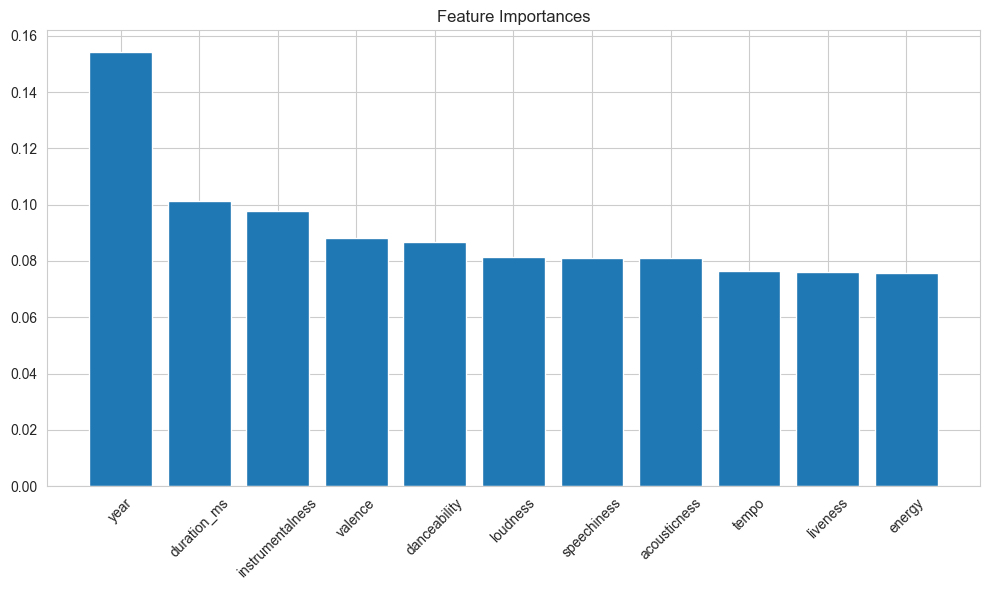

C:\Users\fayca\AppData\Local\Temp\ipykernel_20508\2919379151.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(20).values, y=genre_counts.head(20).index, palette='viridis')


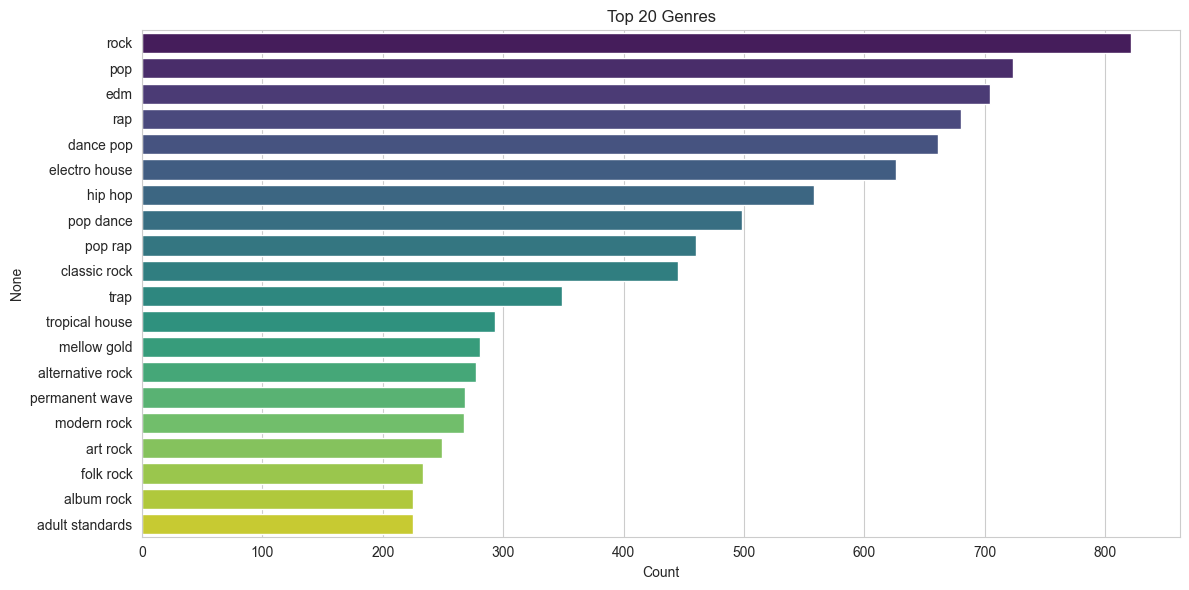

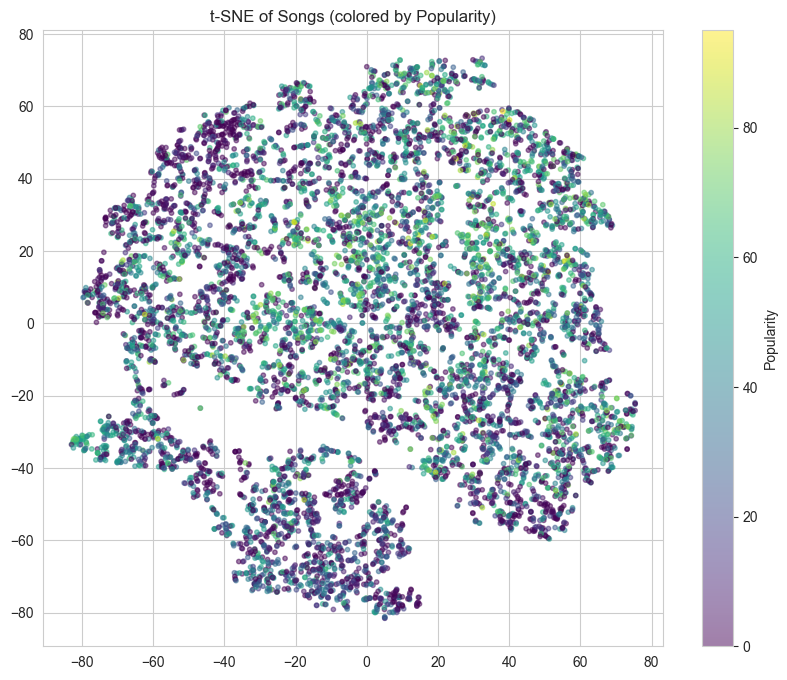

In [8]:
# Analysis Functions (adapted from src/analysis.py)

def load_and_preprocess_subset(filename):
    filepath = get_dataset_path(filename)
    print(f"Loading subset from: {filepath}")
    df = pd.read_csv(filepath)
    # Parse genres
    df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Extract year if needed
    if 'year' not in df.columns and 'release_date' in df.columns:
        df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
    return df

def predict_popularity(df):
    print("--- Popularity Prediction ---")
    numeric_features = ['acousticness', 'danceability', 'energy', 'duration_ms', 
                        'instrumentalness', 'valence', 'tempo', 'liveness', 
                        'loudness', 'speechiness', 'year']
    
    existing_features = [col for col in numeric_features if col in df.columns]
    df_clean = df.dropna(subset=existing_features + ['popularity'])
    
    X = df_clean[existing_features]
    y = df_clean['popularity']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MSE: {mse:.2f}, R2: {r2:.4f}")
    
    # Feature Importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [existing_features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_genres(df):
    all_genres = [genre for genres in df['genres'] for genre in genres]
    genre_counts = pd.Series(all_genres).value_counts()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=genre_counts.head(20).values, y=genre_counts.head(20).index, palette='viridis')
    plt.title('Top 20 Genres')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

def visualize_tsne(df):
    numeric_features = ['acousticness', 'danceability', 'energy', 
                        'instrumentalness', 'valence', 'tempo', 'loudness']
    X = df[numeric_features].dropna()
    X_scaled = StandardScaler().fit_transform(X)
    
    # Use PCA first to reduce to 50 dims for t-SNE speed
    pca = PCA(n_components=min(50, X.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10, c=df.loc[X.index, 'popularity'], cmap='viridis')
    plt.colorbar(label='Popularity')
    plt.title('t-SNE of Songs (colored by Popularity)')
    plt.show()

# Execution
try:
    subset_df = load_and_preprocess_subset('spotify_dataset_subset.csv')
    predict_popularity(subset_df)
    analyze_genres(subset_df)
    visualize_tsne(subset_df)
except FileNotFoundError as e:
    print(e)


## Exercise 3: Recommendation System

We implement a content-based recommender using cosine similarity on audio features.


In [9]:
# Recommender System (adapted from src/recommendation.py)

class Recommender:
    def __init__(self, filename):
        self.filepath = get_dataset_path(filename)
        print(f"Loading recommendation DB from: {self.filepath}")
        self.df = pd.read_csv(self.filepath)
        self.features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                         'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
        self._prepare_data()

    def _prepare_data(self):
        self.df = self.df.dropna(subset=self.features)
        self.scaler = StandardScaler()
        self.feature_matrix = self.scaler.fit_transform(self.df[self.features])
        self.id_to_idx = {id_: idx for idx, id_ in enumerate(self.df['id'])}
        self.idx_to_id = {idx: id_ for idx, id_ in enumerate(self.df['id'])}

    def get_recommendations(self, song_id, n=10):
        if song_id not in self.id_to_idx:
            raise ValueError(f"Song ID {song_id} not found.")
        
        idx = self.id_to_idx[song_id]
        target_vector = self.feature_matrix[idx].reshape(1, -1)
        sim_scores = cosine_similarity(target_vector, self.feature_matrix).flatten()
        
        top_indices = np.argsort(sim_scores)[::-1][1:n+1]
        
        recommendations = []
        for i in top_indices:
            rec_id = self.idx_to_id[i]
            rec_song = self.df.iloc[i]
            recommendations.append({
                'id': rec_id,
                'similarity': sim_scores[i]
            })
        return recommendations

# Demo
try:
    recommender = Recommender('recommendation_spotify.csv')
    if not recommender.df.empty:
        random_id = recommender.df['id'].iloc[0]
        print(f"Generating recommendations for song ID: {random_id}")
        recs = recommender.get_recommendations(random_id)
        for i, rec in enumerate(recs):
            print(f"{i+1}: {rec['id']} (Score: {rec['similarity']:.4f})")
except FileNotFoundError as e:
    print(e)


Loading recommendation DB from: ..\dataset\recommendation_spotify.csv
Generating recommendations for song ID: 0cS0A1fUEUd1EW3FcF8AEI
1: 6fRpNQtnbNTdeUL30TbQgh (Score: 0.9895)
2: 3RiUlqzHWutH43xcGAlfAt (Score: 0.9771)
3: 0X5bMQiFec0YAHsSqcl8zl (Score: 0.9688)
4: 34quhtd2AfsCt4NUxC5WwU (Score: 0.9669)
5: 6Qf9PH6AQRIhTOuoWH1cLJ (Score: 0.9666)
6: 5489YzOo19Ism2xHT5nUaG (Score: 0.9613)
7: 1QO1mUWyD57RBhBbj8HtHM (Score: 0.9608)
8: 76UsyS5qgfUTPfmK7MitEQ (Score: 0.9608)
9: 3QHd6cGq9Gd2JvpfkQ1jvK (Score: 0.9597)
10: 2CWRihgLYV3MLQp6EwPNsr (Score: 0.9597)
